In [1]:
import numpy as np
import pandas as pd

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler


def 降维(feats, nfeats=64):
    scaler = MinMaxScaler()
    pca = PCA(n_components=nfeats)
    new_feats = pca.fit_transform(scaler.fit_transform(feats))
    
    return new_feats

In [4]:
preliminary_a_food = pd.read_csv('./初赛A榜测试集/preliminary_a_food.csv')
preliminary_a_submit_sample = pd.read_csv('./初赛A榜测试集/preliminary_a_submit_sample.csv')
train_food = pd.read_csv('./训练集/train_food.csv')
train_answer = pd.read_csv('./训练集/train_answer.csv')

disease_feature1 = pd.read_csv('./训练集/disease_feature1.csv')
disease_feature2 = pd.read_csv('./训练集/disease_feature2.csv')
disease_feature3 = pd.read_csv('./训练集/disease_feature3.csv')

In [6]:
new_feat1 = 降维(disease_feature1.iloc[:,1:], nfeats=128)
new_feat2 = 降维(disease_feature2.iloc[:,1:], nfeats=200)
new_feat3 = 降维(disease_feature3.iloc[:,1:], nfeats=200)

feat1 = pd.DataFrame(new_feat1)
feat1.columns = [f"pca_1_{i}" for i in range(128)]
feat1['disease_id'] = disease_feature1.disease_id

feat2 = pd.DataFrame(new_feat2)
feat2.columns = [f"pca_2_{i}" for i in range(200)]
feat2['disease_id'] = disease_feature2.disease_id

feat3 = pd.DataFrame(new_feat3)
feat3.columns = [f"pca_3_{i}" for i in range(200)]
feat3['disease_id'] = disease_feature3.disease_id

In [9]:
train_1 = train_answer.merge(train_food,how='left',on=['food_id']).merge(feat1,how='inner',on=['disease_id'])
train_2 = train_answer.merge(train_food,how='left',on=['food_id']).merge(feat2,how='inner',on=['disease_id'])
train_3 = train_answer.merge(train_food,how='left',on=['food_id']).merge(feat3,how='inner',on=['disease_id'])

In [10]:
test_1 = preliminary_a_submit_sample.merge(preliminary_a_food,how='left',on=['food_id']).merge(feat1,how='inner',on=['disease_id'])
test_2 = preliminary_a_submit_sample.merge(preliminary_a_food,how='left',on=['food_id']).merge(feat2,how='inner',on=['disease_id'])
test_3 = preliminary_a_submit_sample.merge(preliminary_a_food,how='left',on=['food_id']).merge(feat3,how='inner',on=['disease_id'])

In [12]:
len(test_1),len(test_2),len(test_3),len(preliminary_a_submit_sample)

(25300, 34615, 45080, 46805)

In [13]:
parameters = {
    'learning_rate': 0.01,
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 63,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'seed': 222222,
    'bagging_seed': 1,
    'feature_fraction_seed': 7,
    'min_data_in_leaf': 20,
    'verbose': -1, 
    'n_jobs':8
}

In [18]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb

drop_cols = ['disease_id', 'food_id', 'related']
feature_name = [f for f in train_1.columns if f not in drop_cols]
X_train = train_1[feature_name].reset_index(drop=True)
X_test = test_1[feature_name].reset_index(drop=True)
y = train_1['related'].reset_index(drop=True)
train_pred = {}
test_pred = {}

seeds = [222222]
num_model_seed = 1
oof = np.zeros(X_train.shape[0])
prediction = np.zeros(X_test.shape[0])
feat_imp_df = pd.DataFrame({'feats': feature_name, 'imp': 0})
fold = 5
for model_seed in range(num_model_seed):
    print(seeds[model_seed],"--------------------------------------------------------------------------------------------")
    oof_cat = np.zeros(X_train.shape[0])
    prediction_cat = np.zeros(X_test.shape[0])
    skf = StratifiedKFold(n_splits=fold, random_state=seeds[model_seed], shuffle=True)
    for index, (train_index, test_index) in enumerate(skf.split(X_train, y)):
        train_x, test_x, train_y, test_y = X_train[feature_name].iloc[train_index], X_train[feature_name].iloc[test_index], y.iloc[train_index], y.iloc[test_index]
        dtrain = lgb.Dataset(train_x, label=train_y)
        dval = lgb.Dataset(test_x, label=test_y)
        lgb_model = lgb.train(
            parameters,
            dtrain,
            num_boost_round=10000,
            valid_sets=[dval],
            early_stopping_rounds=100,
            verbose_eval=100, )
        oof_cat[test_index] += lgb_model.predict(test_x,num_iteration=lgb_model.best_iteration)
        prediction_cat += lgb_model.predict(X_test,num_iteration=lgb_model.best_iteration) / fold
        feat_imp_df['imp'] += lgb_model.feature_importance()

        del train_x
        del test_x
        del train_y
        del test_y
        del lgb_model
    oof += oof_cat / num_model_seed
    prediction += prediction_cat / num_model_seed
# gc.collect()

222222 --------------------------------------------------------------------------------------------


d:\Anaconda3\envs\hahally\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
d:\Anaconda3\envs\hahally\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.936358
[200]	valid_0's auc: 0.948041
[300]	valid_0's auc: 0.955832
[400]	valid_0's auc: 0.960267
[500]	valid_0's auc: 0.963306
[600]	valid_0's auc: 0.965548
[700]	valid_0's auc: 0.967182
[800]	valid_0's auc: 0.968511
[900]	valid_0's auc: 0.969528
[1000]	valid_0's auc: 0.970393
[1100]	valid_0's auc: 0.971006
[1200]	valid_0's auc: 0.971683
[1300]	valid_0's auc: 0.972228
[1400]	valid_0's auc: 0.972656
[1500]	valid_0's auc: 0.973004
[1600]	valid_0's auc: 0.973467
[1700]	valid_0's auc: 0.973901
[1800]	valid_0's auc: 0.974182
[1900]	valid_0's auc: 0.974351
[2000]	valid_0's auc: 0.974562
[2100]	valid_0's auc: 0.974761
[2200]	valid_0's auc: 0.974926
[2300]	valid_0's auc: 0.975061
[2400]	valid_0's auc: 0.975173
[2500]	valid_0's auc: 0.975285
[2600]	valid_0's auc: 0.975421
[2700]	valid_0's auc: 0.975509
[2800]	valid_0's auc: 0.975577
[2900]	valid_0's auc: 0.975654
[3000]	valid_0's auc: 0.975725
[3100]	valid_0's 

In [19]:
train_pred['lgb1'] = oof
test_pred['lgb1'] = prediction

In [20]:
from sklearn.metrics import roc_auc_score
train_pred['lgb1'] = oof
test_pred['lgb1'] = prediction

print("lgb train auc: ", roc_auc_score(y, train_pred['lgb1']))

lgb train auc:  0.9737138552665988


In [21]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb

drop_cols = ['disease_id', 'food_id', 'related']
feature_name = [f for f in train_2.columns if f not in drop_cols]
X_train = train_2[feature_name].reset_index(drop=True)
X_test = test_2[feature_name].reset_index(drop=True)
y = train_2['related'].reset_index(drop=True)
# train_pred = {}
# test_pred = {}

seeds = [222222]
num_model_seed = 1
oof = np.zeros(X_train.shape[0])
prediction = np.zeros(X_test.shape[0])
feat_imp_df = pd.DataFrame({'feats': feature_name, 'imp': 0})
fold = 5
for model_seed in range(num_model_seed):
    print(seeds[model_seed],"--------------------------------------------------------------------------------------------")
    oof_cat = np.zeros(X_train.shape[0])
    prediction_cat = np.zeros(X_test.shape[0])
    skf = StratifiedKFold(n_splits=fold, random_state=seeds[model_seed], shuffle=True)
    for index, (train_index, test_index) in enumerate(skf.split(X_train, y)):
        train_x, test_x, train_y, test_y = X_train[feature_name].iloc[train_index], X_train[feature_name].iloc[test_index], y.iloc[train_index], y.iloc[test_index]
        dtrain = lgb.Dataset(train_x, label=train_y)
        dval = lgb.Dataset(test_x, label=test_y)
        lgb_model = lgb.train(
            parameters,
            dtrain,
            num_boost_round=10000,
            valid_sets=[dval],
            early_stopping_rounds=100,
            verbose_eval=100, )
        oof_cat[test_index] += lgb_model.predict(test_x,num_iteration=lgb_model.best_iteration)
        prediction_cat += lgb_model.predict(X_test,num_iteration=lgb_model.best_iteration) / fold
        feat_imp_df['imp'] += lgb_model.feature_importance()

        del train_x
        del test_x
        del train_y
        del test_y
        del lgb_model
    oof += oof_cat / num_model_seed
    prediction += prediction_cat / num_model_seed
# gc.collect()

222222 --------------------------------------------------------------------------------------------


d:\Anaconda3\envs\hahally\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
d:\Anaconda3\envs\hahally\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.936931
[200]	valid_0's auc: 0.950458
[300]	valid_0's auc: 0.957471
[400]	valid_0's auc: 0.961908
[500]	valid_0's auc: 0.964919
[600]	valid_0's auc: 0.967023
[700]	valid_0's auc: 0.968598
[800]	valid_0's auc: 0.969892
[900]	valid_0's auc: 0.970858
[1000]	valid_0's auc: 0.97159
[1100]	valid_0's auc: 0.972281
[1200]	valid_0's auc: 0.972947
[1300]	valid_0's auc: 0.973329
[1400]	valid_0's auc: 0.973761
[1500]	valid_0's auc: 0.974369
[1600]	valid_0's auc: 0.974698
[1700]	valid_0's auc: 0.974972
[1800]	valid_0's auc: 0.975298
[1900]	valid_0's auc: 0.97564
[2000]	valid_0's auc: 0.975907
[2100]	valid_0's auc: 0.976179
[2200]	valid_0's auc: 0.976457
[2300]	valid_0's auc: 0.976686
[2400]	valid_0's auc: 0.976909
[2500]	valid_0's auc: 0.977037
[2600]	valid_0's auc: 0.977211
[2700]	valid_0's auc: 0.977379
[2800]	valid_0's auc: 0.97752
[2900]	valid_0's auc: 0.977632
[3000]	valid_0's auc: 0.977719
[3100]	valid_0's auc

In [22]:
train_pred['lgb2'] = oof
test_pred['lgb2'] = prediction

print("lgb train auc: ", roc_auc_score(y, train_pred['lgb2']))

lgb train auc:  0.9768468889614703


In [24]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb

drop_cols = ['disease_id', 'food_id', 'related']
feature_name = [f for f in train_3.columns if f not in drop_cols]
X_train = train_3[feature_name].reset_index(drop=True)
X_test = test_3[feature_name].reset_index(drop=True)
y = train_3['related'].reset_index(drop=True)
# train_pred = {}
# test_pred = {}

seeds = [222222]
num_model_seed = 1
oof = np.zeros(X_train.shape[0])
prediction = np.zeros(X_test.shape[0])
feat_imp_df = pd.DataFrame({'feats': feature_name, 'imp': 0})
fold = 5
for model_seed in range(num_model_seed):
    print(seeds[model_seed],"--------------------------------------------------------------------------------------------")
    oof_cat = np.zeros(X_train.shape[0])
    prediction_cat = np.zeros(X_test.shape[0])
    skf = StratifiedKFold(n_splits=fold, random_state=seeds[model_seed], shuffle=True)
    for index, (train_index, test_index) in enumerate(skf.split(X_train, y)):
        train_x, test_x, train_y, test_y = X_train[feature_name].iloc[train_index], X_train[feature_name].iloc[test_index], y.iloc[train_index], y.iloc[test_index]
        dtrain = lgb.Dataset(train_x, label=train_y)
        dval = lgb.Dataset(test_x, label=test_y)
        lgb_model = lgb.train(
            parameters,
            dtrain,
            num_boost_round=10000,
            valid_sets=[dval],
            early_stopping_rounds=100,
            verbose_eval=100, )
        oof_cat[test_index] += lgb_model.predict(test_x,num_iteration=lgb_model.best_iteration)
        prediction_cat += lgb_model.predict(X_test,num_iteration=lgb_model.best_iteration) / fold
        feat_imp_df['imp'] += lgb_model.feature_importance()

        del train_x
        del test_x
        del train_y
        del test_y
        del lgb_model
    oof += oof_cat / num_model_seed
    prediction += prediction_cat / num_model_seed
# gc.collect()

222222 --------------------------------------------------------------------------------------------


d:\Anaconda3\envs\hahally\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
d:\Anaconda3\envs\hahally\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.93334
[200]	valid_0's auc: 0.945648
[300]	valid_0's auc: 0.95342
[400]	valid_0's auc: 0.958125
[500]	valid_0's auc: 0.96106
[600]	valid_0's auc: 0.96331
[700]	valid_0's auc: 0.965191
[800]	valid_0's auc: 0.966668
[900]	valid_0's auc: 0.967816
[1000]	valid_0's auc: 0.968592
[1100]	valid_0's auc: 0.96933
[1200]	valid_0's auc: 0.969982
[1300]	valid_0's auc: 0.97056
[1400]	valid_0's auc: 0.971054
[1500]	valid_0's auc: 0.97153
[1600]	valid_0's auc: 0.972009
[1700]	valid_0's auc: 0.97243
[1800]	valid_0's auc: 0.972827
[1900]	valid_0's auc: 0.973184
[2000]	valid_0's auc: 0.973533
[2100]	valid_0's auc: 0.973809
[2200]	valid_0's auc: 0.974028
[2300]	valid_0's auc: 0.97434
[2400]	valid_0's auc: 0.974526
[2500]	valid_0's auc: 0.97472
[2600]	valid_0's auc: 0.974923
[2700]	valid_0's auc: 0.975113
[2800]	valid_0's auc: 0.97524
[2900]	valid_0's auc: 0.975398
[3000]	valid_0's auc: 0.975524
[3100]	valid_0's auc: 0.9756

In [25]:
train_pred['lgb3'] = oof
test_pred['lgb3'] = prediction

print("lgb train auc: ", roc_auc_score(y, train_pred['lgb3']))

lgb train auc:  0.977371320414361


In [42]:
t1 = train_1[['food_id','disease_id']].reset_index(drop=True)
t1['related_prob_1'] = train_pred['lgb1']

t2 = train_2[['food_id','disease_id']].reset_index(drop=True)
t2['related_prob_2'] = train_pred['lgb2']

t3 = train_3[['food_id','disease_id']].reset_index(drop=True)
t3['related_prob_3'] = train_pred['lgb3']



In [45]:
t = train_answer.merge(t1,on=['food_id','disease_id'],how='left').merge(t2, on=['food_id','disease_id'],how='left').merge(t3,on=['food_id','disease_id'],how='left')

In [47]:
t

,food_id,disease_id,related,related_prob_1,related_prob_2,related_prob_3
0,food_0,disease_998,0,NaN,0.000124,0.000493
1,food_0,disease_861,0,NaN,0.000336,0.000119
2,food_0,disease_559,0,NaN,0.001236,0.001266
3,food_0,disease_841,0,NaN,0.000938,0.000125
4,food_0,disease_81,0,NaN,0.179752,0.188798
...,...,...,...,...,...,...
141631,food_97,disease_841,0,NaN,0.001261,0.001144
141632,food_97,disease_559,0,NaN,0.003440,0.001009
141633,food_97,disease_861,0,NaN,0.000433,0.000120
141634,food_97,disease_1078,0,0.000372,NaN,0.000441


In [49]:
def add(x):
    prob = []
    if x.related_prob_1!=-1:
        prob.append(x.related_prob_1)
    if x.related_prob_2!=-1:
        prob.append(x.related_prob_2)
    if x.related_prob_3!=-1:
        prob.append(x.related_prob_3)
    return sum(prob)/(len(prob))

t = t.fillna(-1)
t['prob'] = t.apply(add,axis=1)
t

,food_id,disease_id,related,related_prob_1,related_prob_2,related_prob_3,prob
0,food_0,disease_998,0,-1.000000,0.000124,0.000493,0.000308
1,food_0,disease_861,0,-1.000000,0.000336,0.000119,0.000227
2,food_0,disease_559,0,-1.000000,0.001236,0.001266,0.001251
3,food_0,disease_841,0,-1.000000,0.000938,0.000125,0.000531
4,food_0,disease_81,0,-1.000000,0.179752,0.188798,0.184275
...,...,...,...,...,...,...,...
141631,food_97,disease_841,0,-1.000000,0.001261,0.001144,0.001203
141632,food_97,disease_559,0,-1.000000,0.003440,0.001009,0.002224
141633,food_97,disease_861,0,-1.000000,0.000433,0.000120,0.000276
141634,food_97,disease_1078,0,0.000372,-1.000000,0.000441,0.000407


In [50]:
print("lgb train auc: ", roc_auc_score(t.related, t['prob']))

lgb train auc:  0.9784415941847765


In [56]:
from sklearn.metrics import f1_score


scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.1,0.9,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (t['prob'].values.reshape((-1)) > threshold).astype('int')
    m = f1_score(t.related.values.reshape((-1)), preds, average='binary')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 

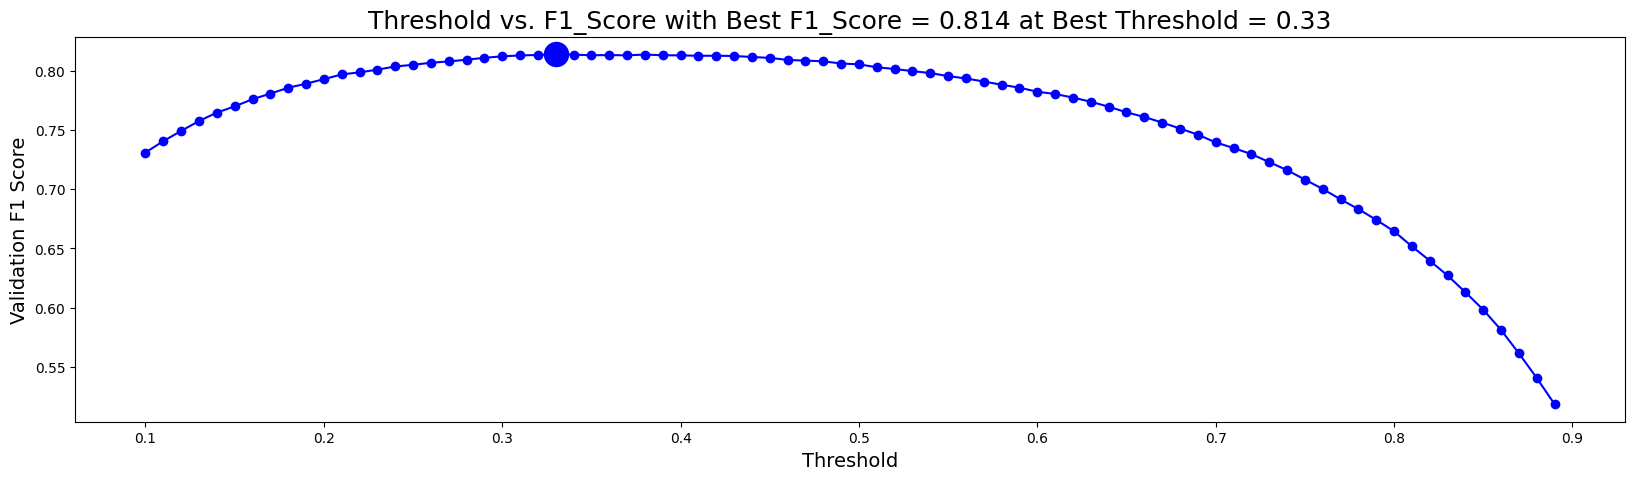

In [57]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [58]:
auc = roc_auc_score(t.related, t['prob'])
f1 = best_score
print((auc + f1) / 2)

0.8963228438125734


In [37]:
sub1 = test_1[['food_id','disease_id']].reset_index(drop=True)
sub1['related_prob_1'] = test_pred['lgb1']

sub2 = test_2[['food_id','disease_id']].reset_index(drop=True)
sub2['related_prob_2'] = test_pred['lgb2']

sub3 = test_3[['food_id','disease_id']].reset_index(drop=True)
sub3['related_prob_3'] = test_pred['lgb3']

In [40]:
sub = preliminary_a_submit_sample.merge(sub1,on=['food_id','disease_id'],how='left').merge(sub2,on=['food_id','disease_id'],how='left').merge(sub3,on=['food_id','disease_id'],how='left')

In [63]:
sub = sub.fillna(-1)
sub['prob'] = sub.apply(add,axis=1)

In [64]:
sub

,food_id,disease_id,related_prob,related_prob_1,related_prob_2,related_prob_3,prob
0,food_10,disease_948,0.1,0.006233,0.004638,0.005374,0.005415
1,food_10,disease_899,0.1,0.000237,0.000132,0.000120,0.000163
2,food_10,disease_841,0.1,-1.000000,0.000640,0.001248,0.000944
3,food_10,disease_81,0.1,-1.000000,0.190460,0.176607,0.183534
4,food_10,disease_201,0.1,0.015797,0.010163,-1.000000,0.012980
...,...,...,...,...,...,...,...
46800,food_99,disease_81,0.1,-1.000000,0.943176,0.932497,0.937836
46801,food_99,disease_841,0.1,-1.000000,0.001935,0.003851,0.002893
46802,food_99,disease_559,0.1,-1.000000,0.022177,0.020024,0.021101
46803,food_99,disease_290,0.1,0.026135,-1.000000,0.014970,0.020552


In [73]:
label=[1 if x >= 0.28+0.22 else 0 for x in sub.prob+0.22]
np.sum(label)

4004

In [74]:
preliminary_a_submit_sample['related_prob'] = sub.prob+0.22

In [75]:
preliminary_a_submit_sample.to_csv('submit_lgb_3m0.22.csv', index=False)